## Naive-Bayes Implementation

I'll implement NB on SMS spam dataset.

I'll also compare it to logistic regression.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv("spam.csv", encoding='latin-1')

# Keep only needed columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


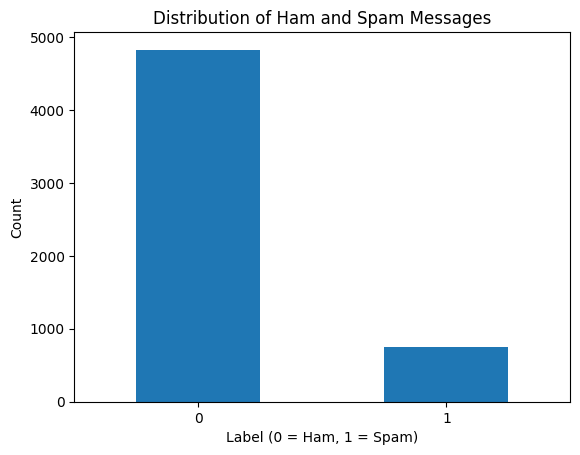

In [ ]:
# Safe label conversion (works whether labels are strings or already numeric)
df['label'] = df['label'].replace({'ham': 0, 'spam': 1})
df['label'] = pd.to_numeric(df['label'], errors='coerce')

if df['label'].isna().all():
	original_labels = pd.read_csv("spam.csv", encoding='latin-1')['v1']
	df['label'] = original_labels.replace({'ham': 0, 'spam': 1})

label_counts = df['label'].value_counts()

label_counts.plot(kind='bar')
plt.title('Distribution of Ham and Spam Messages')
plt.xlabel('Label (0 = Ham, 1 = Spam)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


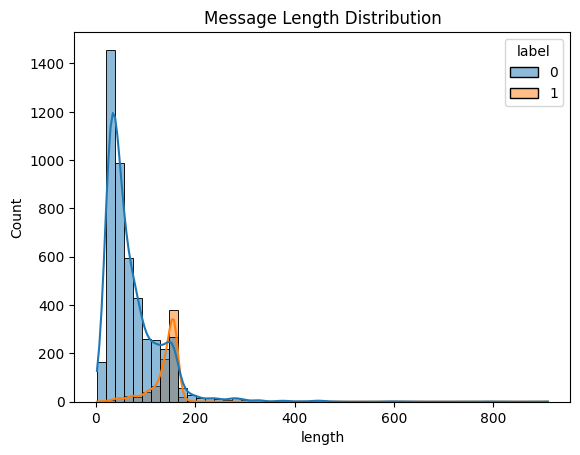

In [25]:
df['length'] = df['message'].apply(len)

sns.histplot(data=df, x='length', hue='label', bins=50, kde=True)
plt.title("Message Length Distribution")
plt.show()

In [ ]:
## observation: spam usually longer, some small too though

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42, stratify=df['label']) 

In [ ]:
vectorizer = CountVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Shape:", X_train_vec.shape)

Shape: (4457, 7701)
Vocabulary size: 7701


In [29]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

y_pred_nb = nb_model.predict(X_test_vec)

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Naive Bayes Confusion Matrix:
[[961   5]
 [ 13 136]]
Naive Bayes Accuracy: 0.9838565022421525


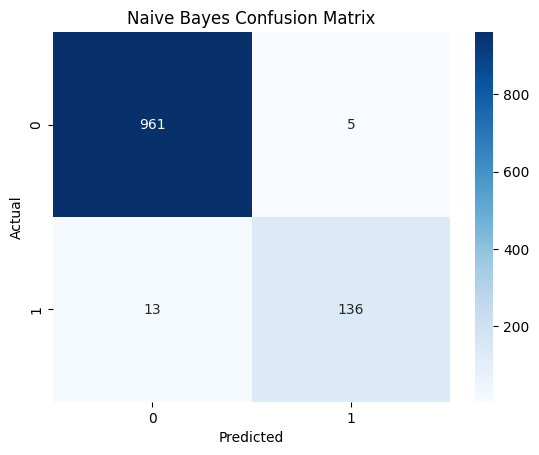

In [30]:
cm = confusion_matrix(y_test, y_pred_nb)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

In [31]:
feature_names = vectorizer.get_feature_names_out()

spam_log_probs = nb_model.feature_log_prob_[1]
ham_log_probs = nb_model.feature_log_prob_[0]

top_spam_indices = np.argsort(spam_log_probs)[-15:]
top_ham_indices = np.argsort(ham_log_probs)[-15:]

print("Top Spam Words:")
print(feature_names[top_spam_indices])

print("\nTop Ham Words:")
print(feature_names[top_ham_indices])

Top Spam Words:
['on' 'from' 'have' 'ur' 'txt' 'is' 'or' 'now' 'the' 'for' 'free' 'your'
 'you' 'call' 'to']

Top Ham Words:
['can' 'have' 'so' 'for' 'of' 'that' 'it' 'my' 'is' 'me' 'in' 'and' 'the'
 'to' 'you']


In [32]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_vec, y_train)

y_pred_log = log_model.predict(X_test_vec)

print("Logistic Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nLogistic Classification Report:\n")
print(classification_report(y_test, y_pred_log))

Logistic Accuracy: 0.9811659192825112

Logistic Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [33]:
## observation:
#1. Naive Bayes is very good at catching spam (high recall) but has more false positives (lower precision).
#2. Logistic Regression is more balanced, with fewer false positives but also slightly lower recall for spam.

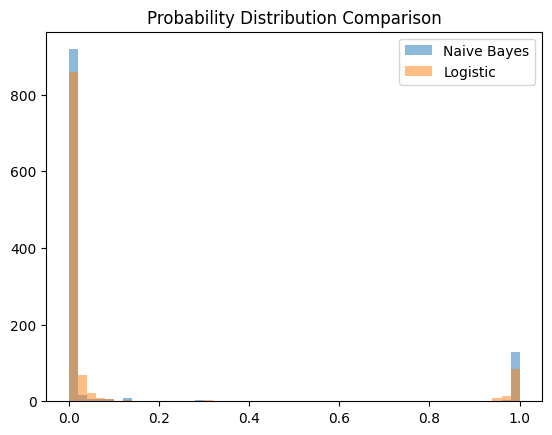

In [35]:
# checking overconfidence

nb_probs = nb_model.predict_proba(X_test_vec)[:, 1]
log_probs = log_model.predict_proba(X_test_vec)[:, 1]

plt.hist(nb_probs, bins=50, alpha=0.5, label="Naive Bayes")
plt.hist(log_probs, bins=50, alpha=0.5, label="Logistic")
plt.legend()
plt.title("Probability Distribution Comparison")
plt.show()

In [36]:
# threshold tuning for Naive Bayes

threshold = 0.3
y_pred_nb_thresh = (nb_probs >= threshold).astype(int)
print("Naive Bayes Classification Report (Threshold = 0.3):")
print(classification_report(y_test, y_pred_nb_thresh))

Naive Bayes Classification Report (Threshold = 0.3):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.97      0.93      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [38]:
# observation: Lowering the threshold to 0.3 increases recall for spam but also increases false positives, leading to lower precision.